In [1]:
import os
import pickle
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from pynvml import nvmlInit, nvmlDeviceGetCount, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlShutdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


In [2]:
def select_gpu_with_most_free_memory():
    nvmlInit()
    device_count = nvmlDeviceGetCount()
    max_free_mem = 0
    best_gpu = 0
    for i in range(device_count):
        handle = nvmlDeviceGetHandleByIndex(i)
        mem_info = nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        print(f"GPU {i}: Free Memory: {free_mem / 1024 ** 2:.2f} MB")
        if free_mem > max_free_mem:
            max_free_mem = free_mem
            best_gpu = i
    nvmlShutdown()
    return best_gpu

# Select the GPU with most free memory
best_gpu_index = select_gpu_with_most_free_memory()

device = torch.device(f"cuda:{best_gpu_index}" if torch.cuda.is_available() else "cpu")
print("CUDA Available:", torch.cuda.is_available())
print("Selected GPU Index:", best_gpu_index)
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(best_gpu_index))

GPU 0: Free Memory: 12189.75 MB
GPU 1: Free Memory: 12189.75 MB
GPU 2: Free Memory: 12189.75 MB
GPU 3: Free Memory: 12181.94 MB
CUDA Available: True
Selected GPU Index: 0
Device Name: NVIDIA TITAN Xp


In [3]:
class DaiseeCombinedFeaturesDataset(Dataset):
    """
    Dataset that returns (full_features, face_features) together with label.
    """
    def __init__(self, full_features_file, face_features_file, labels_file):
        with open(full_features_file, "rb") as f:
            self.full_features = pickle.load(f)
        with open(face_features_file, "rb") as f:
            self.face_features = pickle.load(f)
        with open(labels_file, "rb") as f:
            self.labels = pickle.load(f)
        
        self.labels = np.array(self.labels)

        # Filter out corrupted samples (None values)
        clean_full = []
        clean_face = []
        clean_labels = []
        
        for full_feat, face_feat, lbl in zip(self.full_features, self.face_features, self.labels):
            if full_feat is not None and face_feat is not None:
                clean_full.append(full_feat)
                clean_face.append(face_feat)
                clean_labels.append(lbl)

        self.full_features = clean_full
        self.face_features = clean_face
        self.labels = clean_labels

    def __len__(self):
        return len(self.full_features)

    def __getitem__(self, idx):
        full_feat = torch.tensor(self.full_features[idx], dtype=torch.float32)
        face_feat = torch.tensor(self.face_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return (full_feat, face_feat), label

In [4]:
# File paths for the pickle files (update these paths as needed)
# train_features_file = "efficientNet_features/daisee_video_features_60.pkl"
# train_labels_file   = "efficientNet_features/daisee_labels_60.pkl"
# val_features_file   = "efficientNet_features/daisee_val_video_features_60.pkl"
# val_labels_file     = "efficientNet_features/daisee_val_labels_60.pkl"
# test_features_file  = "efficientNet_features/daisee_test_video_features_60.pkl"
# test_labels_file    = "efficientNet_features/daisee_test_labels_60.pkl"
# train_features_file = "efficientNet_features/daisee_train_video_features_aug_60.pkl"
# train_labels_file   = "efficientNet_features/daisee_train_labels_aug_60.pkl"
# val_features_file   = "efficientNet_features/daisee_val_video_features_aug_60.pkl"
# val_labels_file     = "efficientNet_features/daisee_val_labels_aug_60.pkl"
# test_features_file  = "efficientNet_features/daisee_test_video_features_aug_60.pkl"
# test_labels_file    = "efficientNet_features/daisee_test_labels_aug_60.pkl"
train_features_full_file = "efficientNet_features/daisee_train_video_features_v2_aug_60.pkl"
train_features_face_file = "efficientNet_features/daisee_train_video_features_face_v2_aug_60.pkl"
train_labels_file   = "efficientNet_features/daisee_train_labels_v2_aug_60.pkl"
val_features_full_file   = "efficientNet_features/daisee_val_video_features_v2_aug_60.pkl"
val_features_face_file   = "efficientNet_features/daisee_val_video_features_face_v2_aug_60.pkl"
val_labels_file     = "efficientNet_features/daisee_val_labels_v2_aug_60.pkl"
test_features_full_file  = "efficientNet_features/daisee_test_video_features_v2_aug_60.pkl"
test_features_face_file  = "efficientNet_features/daisee_test_video_features_face_v2_aug_60.pkl"
test_labels_file    = "efficientNet_features/daisee_test_labels_v2_aug_60.pkl"

# Train / Val / Test datasets
train_dataset = DaiseeCombinedFeaturesDataset(train_features_full_file, train_features_face_file, train_labels_file)
val_dataset = DaiseeCombinedFeaturesDataset(val_features_full_file, val_features_face_file, val_labels_file)
test_dataset = DaiseeCombinedFeaturesDataset(test_features_full_file, test_features_face_file, test_labels_file)

# Loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:


class LearnablePositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super(LearnablePositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        return x + self.pos_embedding[:, :x.size(1)]

class CustomTransformerModel(nn.Module):
    def __init__(self, input_dim=1280, seq_len=60, nhead=8, hidden_dim=1024, ff_dim=2048, num_layers=2, dropout=0.1):
        super(CustomTransformerModel, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim = hidden_dim

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))

        # Project input to model dimension
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Learnable positional encoding
        self.pos_encoder = LearnablePositionalEncoding(max_len=seq_len + 1, d_model=hidden_dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        """
        Args:
            x: (B, seq_len, input_dim)
        Returns:
            (B, hidden_dim) from CLS token
        """
        B = x.size(0)

        x = self.input_projection(x)  # (B, 60, 1024)

        # Prepend CLS token
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, 1024)
        x = torch.cat((cls_token, x), dim=1)  # (B, 61, 1024)

        x = self.pos_encoder(x)
        x = self.dropout(x)

        x = self.transformer_encoder(x)  # (B, 61, 1024)

        cls_out = x[:, 0]  # Take only the CLS token output
        cls_out = self.norm(cls_out)
        return cls_out  # Final feature vector per sample

In [6]:
# Determine feature dimension and sequence length from training data
(sample_full, sample_face), _ = train_dataset[0]
seq_length, feature_dim = sample_full.shape
print("Sequence length:", seq_length, "Feature dimension:", feature_dim)

hidden_size=1024
num_classes=4
input_dim=1280

Sequence length: 60 Feature dimension: 1280


In [7]:
# Model for full frame features
model_full = CustomTransformerModel().to(device)

# Model for face features
model_face = CustomTransformerModel().to(device)

# MLP to combine outputs
combined_feature_size = hidden_size * 2 # concatenate output of the two LSTM models
mlp_classifier = nn.Sequential(
    nn.Linear(combined_feature_size, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
).to(device)

/home/prateek/.conda/envs/venv-pr-01-pt/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
def train_combined_model(model_full, model_face, mlp_classifier,
                         train_loader, val_loader,
                         num_epochs, criterion, optimizer,
                         device,
                         save_path="models/best_combined_transformer_model.pt"):
    
    model_full.train()
    model_face.train()
    mlp_classifier.train()
    
    train_losses = []
    val_losses = []
    epoch_times = []
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)
        start_time.record()
        
        total_loss = 0.0
        
        for (batch_full, batch_face), batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch_full = batch_full.to(device)  # (B, 60, 1028)
            batch_face = batch_face.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            full_feat = model_full(batch_full)    # (B, 1024)
            face_feat = model_face(batch_face)    # (B, 1024)

            combined_feat = torch.cat((full_feat, face_feat), dim=1)  # (B, 2048)
            logits = mlp_classifier(combined_feat)

            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch_full.size(0)
        
        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation
        model_full.eval()
        model_face.eval()
        mlp_classifier.eval()
        
        total_val_loss = 0.0
        with torch.no_grad():
            for (x_full_val, x_face_val), y_val in val_loader:
                x_full_val = x_full_val.to(device)
                x_face_val = x_face_val.to(device)
                y_val = y_val.to(device)

                full_val = model_full(x_full_val)
                face_val = model_face(x_face_val)

                combined_val = torch.cat((full_val, face_val), dim=1)
                logits_val = mlp_classifier(combined_val)

                loss_val = criterion(logits_val, y_val)
                total_val_loss += loss_val.item() * x_full_val.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        end_time.record()
        torch.cuda.synchronize()
        epoch_time = start_time.elapsed_time(end_time) / 1000.0
        epoch_times.append(epoch_time)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f} sec")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_dict = {
                'model_full_state_dict': model_full.state_dict(),
                'model_face_state_dict': model_face.state_dict(),
                'mlp_classifier_state_dict': mlp_classifier.state_dict()
            }
            torch.save(save_dict, save_path)
            print(f"Saved best model at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

        model_full.train()
        model_face.train()
        mlp_classifier.train()

    # Plot Training vs Validation Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, epoch_times

In [9]:
def ordinal_cross_entropy_loss(logits, target, num_classes=4):
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=1)  # Shape: (batch_size, num_classes)
    
    # Create a tensor of class indices
    class_indices = torch.arange(num_classes, device=logits.device, dtype=torch.float)
    
    # Compute the expected value for each sample (weighted average of class indices)
    expected = torch.sum(probs * class_indices.unsqueeze(0), dim=1)  # Shape: (batch_size,)
    
    # Use Mean Squared Error loss to measure the difference between expected value and true label
    loss = F.mse_loss(expected, target.float())
    return loss

Epoch 1/80: 100%|██████████| 288/288 [00:42<00:00,  6.74it/s]


Epoch 1/80 - Train Loss: 0.9771, Val Loss: 0.9877, Time: 45.36 sec
Saved best model at epoch 1 with Val Loss: 0.9877


Epoch 2/80: 100%|██████████| 288/288 [00:44<00:00,  6.44it/s]


Epoch 2/80 - Train Loss: 0.9466, Val Loss: 0.9789, Time: 47.36 sec
Saved best model at epoch 2 with Val Loss: 0.9789


Epoch 3/80: 100%|██████████| 288/288 [00:45<00:00,  6.30it/s]


Epoch 3/80 - Train Loss: 0.9370, Val Loss: 0.9788, Time: 48.56 sec
Saved best model at epoch 3 with Val Loss: 0.9788


Epoch 4/80: 100%|██████████| 288/288 [00:45<00:00,  6.32it/s]


Epoch 4/80 - Train Loss: 0.9283, Val Loss: 0.9722, Time: 48.32 sec
Saved best model at epoch 4 with Val Loss: 0.9722


Epoch 5/80: 100%|██████████| 288/288 [00:46<00:00,  6.25it/s]


Epoch 5/80 - Train Loss: 0.9191, Val Loss: 0.9699, Time: 48.97 sec
Saved best model at epoch 5 with Val Loss: 0.9699


Epoch 6/80: 100%|██████████| 288/288 [00:46<00:00,  6.18it/s]


Epoch 6/80 - Train Loss: 0.9129, Val Loss: 0.9475, Time: 49.29 sec
Saved best model at epoch 6 with Val Loss: 0.9475


Epoch 7/80: 100%|██████████| 288/288 [00:46<00:00,  6.23it/s]


Epoch 7/80 - Train Loss: 0.9086, Val Loss: 0.9570, Time: 48.88 sec


Epoch 8/80: 100%|██████████| 288/288 [00:47<00:00,  6.10it/s]


Epoch 8/80 - Train Loss: 0.9147, Val Loss: 0.9589, Time: 49.53 sec


Epoch 9/80: 100%|██████████| 288/288 [00:46<00:00,  6.14it/s]


Epoch 9/80 - Train Loss: 0.9095, Val Loss: 0.9623, Time: 49.70 sec


Epoch 10/80: 100%|██████████| 288/288 [00:46<00:00,  6.16it/s]


Epoch 10/80 - Train Loss: 0.9072, Val Loss: 1.0069, Time: 49.43 sec


Epoch 11/80: 100%|██████████| 288/288 [00:46<00:00,  6.20it/s]


Epoch 11/80 - Train Loss: 0.8994, Val Loss: 0.9260, Time: 49.06 sec
Saved best model at epoch 11 with Val Loss: 0.9260


Epoch 12/80: 100%|██████████| 288/288 [00:46<00:00,  6.13it/s]


Epoch 12/80 - Train Loss: 0.8975, Val Loss: 0.9348, Time: 49.55 sec


Epoch 13/80: 100%|██████████| 288/288 [00:46<00:00,  6.24it/s]


Epoch 13/80 - Train Loss: 0.8891, Val Loss: 0.9180, Time: 48.92 sec
Saved best model at epoch 13 with Val Loss: 0.9180


Epoch 14/80: 100%|██████████| 288/288 [00:46<00:00,  6.14it/s]


Epoch 14/80 - Train Loss: 0.8860, Val Loss: 0.9616, Time: 49.65 sec


Epoch 15/80: 100%|██████████| 288/288 [00:46<00:00,  6.19it/s]


Epoch 15/80 - Train Loss: 0.8849, Val Loss: 0.9164, Time: 49.24 sec
Saved best model at epoch 15 with Val Loss: 0.9164


Epoch 16/80: 100%|██████████| 288/288 [00:46<00:00,  6.14it/s]


Epoch 16/80 - Train Loss: 0.8783, Val Loss: 0.9143, Time: 49.04 sec
Saved best model at epoch 16 with Val Loss: 0.9143


Epoch 17/80: 100%|██████████| 288/288 [00:47<00:00,  6.04it/s]


Epoch 17/80 - Train Loss: 0.8768, Val Loss: 0.9174, Time: 50.10 sec


Epoch 18/80: 100%|██████████| 288/288 [00:46<00:00,  6.15it/s]


Epoch 18/80 - Train Loss: 0.8736, Val Loss: 0.9090, Time: 49.60 sec
Saved best model at epoch 18 with Val Loss: 0.9090


Epoch 19/80: 100%|██████████| 288/288 [00:46<00:00,  6.16it/s]


Epoch 19/80 - Train Loss: 0.8723, Val Loss: 0.9247, Time: 49.39 sec


Epoch 20/80: 100%|██████████| 288/288 [00:46<00:00,  6.16it/s]


Epoch 20/80 - Train Loss: 0.8725, Val Loss: 0.9189, Time: 49.42 sec


Epoch 21/80: 100%|██████████| 288/288 [00:47<00:00,  6.04it/s]


Epoch 21/80 - Train Loss: 0.8699, Val Loss: 0.9348, Time: 50.36 sec


Epoch 22/80: 100%|██████████| 288/288 [00:29<00:00,  9.88it/s]


Epoch 22/80 - Train Loss: 0.8727, Val Loss: 0.9127, Time: 30.74 sec


Epoch 23/80: 100%|██████████| 288/288 [00:22<00:00, 12.78it/s]


Epoch 23/80 - Train Loss: 0.8665, Val Loss: 0.9247, Time: 24.06 sec


Epoch 24/80: 100%|██████████| 288/288 [00:22<00:00, 12.81it/s]


Epoch 24/80 - Train Loss: 0.8689, Val Loss: 0.9010, Time: 24.01 sec
Saved best model at epoch 24 with Val Loss: 0.9010


Epoch 25/80: 100%|██████████| 288/288 [00:22<00:00, 12.76it/s]


Epoch 25/80 - Train Loss: 0.8704, Val Loss: 0.8908, Time: 24.08 sec
Saved best model at epoch 25 with Val Loss: 0.8908


Epoch 26/80: 100%|██████████| 288/288 [00:22<00:00, 12.66it/s]


Epoch 26/80 - Train Loss: 0.8666, Val Loss: 0.8973, Time: 24.32 sec


Epoch 27/80: 100%|██████████| 288/288 [00:22<00:00, 12.83it/s]


Epoch 27/80 - Train Loss: 0.8629, Val Loss: 0.8924, Time: 23.99 sec


Epoch 28/80: 100%|██████████| 288/288 [00:22<00:00, 12.75it/s]


Epoch 28/80 - Train Loss: 0.8617, Val Loss: 0.8909, Time: 24.12 sec


Epoch 29/80: 100%|██████████| 288/288 [00:22<00:00, 12.86it/s]


Epoch 29/80 - Train Loss: 0.8596, Val Loss: 0.8935, Time: 23.89 sec


Epoch 30/80: 100%|██████████| 288/288 [00:22<00:00, 12.62it/s]


Epoch 30/80 - Train Loss: 0.8571, Val Loss: 0.9065, Time: 24.42 sec


Epoch 31/80: 100%|██████████| 288/288 [00:22<00:00, 12.86it/s]


Epoch 31/80 - Train Loss: 0.8616, Val Loss: 0.8904, Time: 23.91 sec
Saved best model at epoch 31 with Val Loss: 0.8904


Epoch 32/80: 100%|██████████| 288/288 [00:22<00:00, 12.83it/s]


Epoch 32/80 - Train Loss: 0.8545, Val Loss: 0.9140, Time: 23.94 sec


Epoch 33/80: 100%|██████████| 288/288 [00:22<00:00, 12.77it/s]


Epoch 33/80 - Train Loss: 0.8516, Val Loss: 0.9145, Time: 24.12 sec


Epoch 34/80: 100%|██████████| 288/288 [00:22<00:00, 12.80it/s]


Epoch 34/80 - Train Loss: 0.8515, Val Loss: 0.9405, Time: 24.01 sec


Epoch 35/80: 100%|██████████| 288/288 [00:22<00:00, 12.76it/s]


Epoch 35/80 - Train Loss: 0.8656, Val Loss: 0.8895, Time: 24.08 sec
Saved best model at epoch 35 with Val Loss: 0.8895


Epoch 36/80: 100%|██████████| 288/288 [00:22<00:00, 12.84it/s]


Epoch 36/80 - Train Loss: 0.8584, Val Loss: 0.9033, Time: 23.94 sec


Epoch 37/80: 100%|██████████| 288/288 [00:22<00:00, 12.81it/s]


Epoch 37/80 - Train Loss: 0.8545, Val Loss: 0.8941, Time: 24.03 sec


Epoch 38/80: 100%|██████████| 288/288 [00:22<00:00, 12.85it/s]


Epoch 38/80 - Train Loss: 0.8496, Val Loss: 0.8927, Time: 23.91 sec


Epoch 39/80: 100%|██████████| 288/288 [00:22<00:00, 12.72it/s]


Epoch 39/80 - Train Loss: 0.8508, Val Loss: 0.8974, Time: 24.15 sec


Epoch 40/80: 100%|██████████| 288/288 [00:22<00:00, 12.68it/s]


Epoch 40/80 - Train Loss: 0.8456, Val Loss: 0.8917, Time: 24.21 sec


Epoch 41/80: 100%|██████████| 288/288 [00:22<00:00, 12.81it/s]


Epoch 41/80 - Train Loss: 0.8463, Val Loss: 0.8959, Time: 24.00 sec


Epoch 42/80: 100%|██████████| 288/288 [00:22<00:00, 12.87it/s]


Epoch 42/80 - Train Loss: 0.8497, Val Loss: 0.9117, Time: 23.87 sec


Epoch 43/80: 100%|██████████| 288/288 [00:22<00:00, 12.78it/s]


Epoch 43/80 - Train Loss: 0.8630, Val Loss: 1.0577, Time: 24.09 sec


Epoch 44/80: 100%|██████████| 288/288 [00:22<00:00, 12.84it/s]


Epoch 44/80 - Train Loss: 0.8514, Val Loss: 0.9029, Time: 23.93 sec


Epoch 45/80: 100%|██████████| 288/288 [00:22<00:00, 12.83it/s]


Epoch 45/80 - Train Loss: 0.8424, Val Loss: 0.9173, Time: 23.96 sec


Epoch 46/80: 100%|██████████| 288/288 [00:22<00:00, 12.54it/s]


Epoch 46/80 - Train Loss: 0.8445, Val Loss: 0.8774, Time: 24.51 sec
Saved best model at epoch 46 with Val Loss: 0.8774


Epoch 47/80: 100%|██████████| 288/288 [00:22<00:00, 12.75it/s]


Epoch 47/80 - Train Loss: 0.8412, Val Loss: 0.8873, Time: 24.09 sec


Epoch 48/80: 100%|██████████| 288/288 [00:22<00:00, 12.83it/s]


Epoch 48/80 - Train Loss: 0.8399, Val Loss: 0.8817, Time: 23.95 sec


Epoch 49/80: 100%|██████████| 288/288 [00:22<00:00, 12.76it/s]


Epoch 49/80 - Train Loss: 0.8444, Val Loss: 0.9185, Time: 24.13 sec


Epoch 50/80: 100%|██████████| 288/288 [00:22<00:00, 12.81it/s]


Epoch 50/80 - Train Loss: 0.8474, Val Loss: 0.8896, Time: 23.99 sec


Epoch 51/80: 100%|██████████| 288/288 [00:22<00:00, 12.90it/s]


Epoch 51/80 - Train Loss: 0.8476, Val Loss: 0.8905, Time: 23.83 sec


Epoch 52/80: 100%|██████████| 288/288 [00:22<00:00, 12.87it/s]


Epoch 52/80 - Train Loss: 0.8467, Val Loss: 0.8804, Time: 23.92 sec


Epoch 53/80: 100%|██████████| 288/288 [00:23<00:00, 12.44it/s]


Epoch 53/80 - Train Loss: 0.8443, Val Loss: 0.9889, Time: 24.64 sec


Epoch 54/80: 100%|██████████| 288/288 [00:22<00:00, 12.80it/s]


Epoch 54/80 - Train Loss: 0.8483, Val Loss: 0.9080, Time: 24.02 sec


Epoch 55/80: 100%|██████████| 288/288 [00:22<00:00, 12.73it/s]


Epoch 55/80 - Train Loss: 0.8464, Val Loss: 0.8807, Time: 24.13 sec


Epoch 56/80: 100%|██████████| 288/288 [00:22<00:00, 12.71it/s]


Epoch 56/80 - Train Loss: 0.8422, Val Loss: 0.8849, Time: 24.16 sec


Epoch 57/80: 100%|██████████| 288/288 [00:22<00:00, 12.81it/s]


Epoch 57/80 - Train Loss: 0.8366, Val Loss: 0.8949, Time: 24.03 sec


Epoch 58/80: 100%|██████████| 288/288 [00:22<00:00, 12.58it/s]


Epoch 58/80 - Train Loss: 0.8412, Val Loss: 0.8847, Time: 24.39 sec


Epoch 59/80: 100%|██████████| 288/288 [00:22<00:00, 12.74it/s]


Epoch 59/80 - Train Loss: 0.8382, Val Loss: 0.8952, Time: 24.11 sec


Epoch 60/80: 100%|██████████| 288/288 [00:22<00:00, 12.70it/s]


Epoch 60/80 - Train Loss: 0.8373, Val Loss: 0.9262, Time: 24.22 sec


Epoch 61/80: 100%|██████████| 288/288 [00:23<00:00, 12.52it/s]


Epoch 61/80 - Train Loss: 0.8342, Val Loss: 0.8774, Time: 24.54 sec
Saved best model at epoch 61 with Val Loss: 0.8774


Epoch 62/80: 100%|██████████| 288/288 [00:22<00:00, 12.69it/s]


Epoch 62/80 - Train Loss: 0.8347, Val Loss: 0.8793, Time: 24.19 sec


Epoch 63/80: 100%|██████████| 288/288 [00:22<00:00, 12.93it/s]


Epoch 63/80 - Train Loss: 0.8374, Val Loss: 0.9046, Time: 23.80 sec


Epoch 64/80: 100%|██████████| 288/288 [00:22<00:00, 12.52it/s]


Epoch 64/80 - Train Loss: 0.8457, Val Loss: 0.8851, Time: 24.50 sec


Epoch 65/80: 100%|██████████| 288/288 [00:22<00:00, 12.68it/s]


Epoch 65/80 - Train Loss: 0.8392, Val Loss: 0.9073, Time: 24.21 sec


Epoch 66/80: 100%|██████████| 288/288 [00:22<00:00, 12.66it/s]


Epoch 66/80 - Train Loss: 0.8406, Val Loss: 0.8882, Time: 24.28 sec


Epoch 67/80: 100%|██████████| 288/288 [00:22<00:00, 12.71it/s]


Epoch 67/80 - Train Loss: 0.8343, Val Loss: 0.8806, Time: 24.16 sec


Epoch 68/80: 100%|██████████| 288/288 [00:22<00:00, 12.84it/s]


Epoch 68/80 - Train Loss: 0.8366, Val Loss: 0.8892, Time: 23.93 sec


Epoch 69/80: 100%|██████████| 288/288 [00:22<00:00, 12.86it/s]


Epoch 69/80 - Train Loss: 0.8282, Val Loss: 0.8773, Time: 23.90 sec
Saved best model at epoch 69 with Val Loss: 0.8773


Epoch 70/80: 100%|██████████| 288/288 [00:23<00:00, 12.49it/s]


Epoch 70/80 - Train Loss: 0.8303, Val Loss: 0.9069, Time: 24.53 sec


Epoch 71/80: 100%|██████████| 288/288 [00:22<00:00, 12.82it/s]


Epoch 71/80 - Train Loss: 0.8324, Val Loss: 0.8644, Time: 23.99 sec
Saved best model at epoch 71 with Val Loss: 0.8644


Epoch 72/80: 100%|██████████| 288/288 [00:22<00:00, 12.63it/s]


Epoch 72/80 - Train Loss: 0.8299, Val Loss: 0.8708, Time: 24.30 sec


Epoch 73/80: 100%|██████████| 288/288 [00:23<00:00, 12.50it/s]


Epoch 73/80 - Train Loss: 0.8357, Val Loss: 0.8997, Time: 24.65 sec


Epoch 74/80: 100%|██████████| 288/288 [00:23<00:00, 12.31it/s]


Epoch 74/80 - Train Loss: 0.8350, Val Loss: 0.8713, Time: 25.13 sec


Epoch 75/80: 100%|██████████| 288/288 [00:23<00:00, 12.42it/s]


Epoch 75/80 - Train Loss: 0.8324, Val Loss: 0.8779, Time: 24.77 sec


Epoch 76/80: 100%|██████████| 288/288 [00:23<00:00, 12.40it/s]


Epoch 76/80 - Train Loss: 0.8349, Val Loss: 0.8711, Time: 24.84 sec


Epoch 77/80: 100%|██████████| 288/288 [00:22<00:00, 12.56it/s]


Epoch 77/80 - Train Loss: 0.8333, Val Loss: 0.8675, Time: 24.56 sec


Epoch 78/80: 100%|██████████| 288/288 [00:22<00:00, 12.55it/s]


Epoch 78/80 - Train Loss: 0.8324, Val Loss: 0.9429, Time: 24.51 sec


Epoch 79/80: 100%|██████████| 288/288 [00:22<00:00, 12.60it/s]


Epoch 79/80 - Train Loss: 0.8334, Val Loss: 0.8777, Time: 24.50 sec


Epoch 80/80: 100%|██████████| 288/288 [00:23<00:00, 12.32it/s]


Epoch 80/80 - Train Loss: 0.8235, Val Loss: 0.9027, Time: 24.97 sec


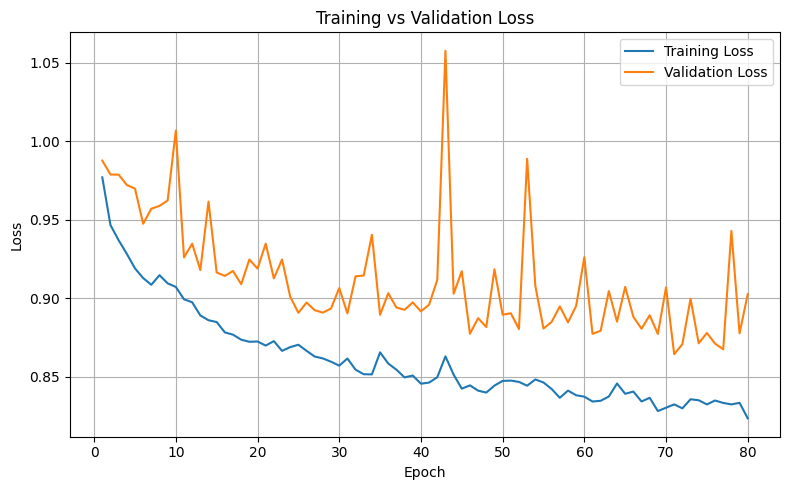

In [10]:
# Choose CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()
# criterion = ordinal_cross_entropy_loss

optimizer = optim.Adam(
    list(model_full.parameters()) + list(model_face.parameters()) + list(mlp_classifier.parameters()),
    lr=1e-3
)

# Set number of epochs and train the model
num_epochs = 80
train_losses, val_losses, epoch_times = train_combined_model(model_full, model_face, mlp_classifier, train_loader, val_loader, num_epochs, criterion, optimizer, device)

In [11]:
def evaluate_model(model, test_loader, criterion, device, class_names=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (x_full, x_face), y_test in test_loader:
            x_full = x_full.to(device)
            x_face = x_face.to(device)
            y_test = y_test.to(device)
            
            logits_test = model(x_full, x_face)
            loss = criterion(logits_test, y_test)
            
            total_loss += loss.item() * x_full.size(0)
            preds = torch.argmax(logits_test, dim=1)
            total_correct += (preds == y_test).sum().item()
            total_samples += x_full.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [12]:
class CombinedModel(nn.Module):
    def __init__(self, model_full, model_face, mlp_classifier):
        super(CombinedModel, self).__init__()
        self.model_full = model_full
        self.model_face = model_face
        self.mlp_classifier = mlp_classifier

    def forward(self, x_full, x_face):
        full_out = self.model_full(x_full)
        face_out = self.model_face(x_face)
        combined = torch.cat((full_out, face_out), dim=1)  # concatenate on feature dimension
        logits = self.mlp_classifier(combined)
        return logits

Test Loss: 0.7610, Test Accuracy: 0.6239


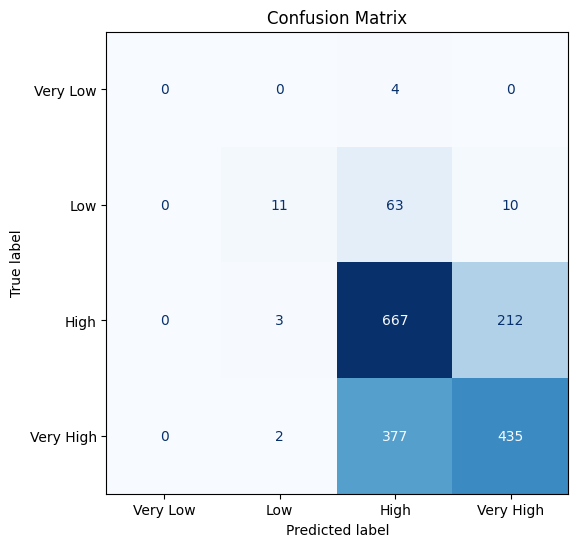


Classification Report:
              precision    recall  f1-score   support

    Very Low       0.00      0.00      0.00         4
         Low       0.69      0.13      0.22        84
        High       0.60      0.76      0.67       882
   Very High       0.66      0.53      0.59       814

    accuracy                           0.62      1784
   macro avg       0.49      0.36      0.37      1784
weighted avg       0.63      0.62      0.61      1784



/home/prateek/.conda/envs/venv-pr-01-pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prateek/.conda/envs/venv-pr-01-pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prateek/.conda/envs/venv-pr-01-pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [13]:
combined_model = CombinedModel(model_full, model_face, mlp_classifier).to(device)

# Load the separately saved state dicts
checkpoint = torch.load("models/best_combined_transformer_model.pt",weights_only=True)

# Load them into the corresponding parts
combined_model.model_full.load_state_dict(checkpoint['model_full_state_dict'])
combined_model.model_face.load_state_dict(checkpoint['model_face_state_dict'])
combined_model.mlp_classifier.load_state_dict(checkpoint['mlp_classifier_state_dict'])

combined_model.to(device)
combined_model.eval()

class_names = ["Very Low", "Low", "High", "Very High"]
evaluate_model(combined_model, test_loader, criterion, device, class_names)